<a href="https://colab.research.google.com/github/danielalcalde/MCMC_CRBM/blob/master/Ising_CRBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simulating the Ising model using an CRBM

## Abstract:
Machine learning is becoming widely used in analyzing the thermodynamics of many-body condensed matter systems.
Restricted Boltzmann Machine (RBM) aided Montecarlo simulations have sparked interest recently as they manage to speed up classical Monte Carlo simulations.
Here we employ the Convolutional Restricted Boltzmann Machine (CRBM) method and show that its use helps to reduce the number of parameters to be learned drastically by taking advantage of translation invariance. Furthermore, we show that it is possible to train the CRBM at smaller lattice sizes, and apply it to bigger lattice sizes. To demonstrate the efficiency of CRBM we apply it to the paradigmatic  Ising and Kitaev models in two dimensions.

## Paper:
paper link

## Introduction
This Notebook is intended as an educational tool for the use of Convolutional Restricted Boltzmann Machines in classical Montecarlo simulations. The code for the paper was written with the library Theano, which will no longer be updated, that is why we have chosen to present the main concept in TensorFlow. Specifically, this notebook only tackles the Ising model. As there is only the nearest neighbor interaction, we can teach the CRBM using 3X3 states, this has as a consequence that we are able to generate all possible states $2^{3*3}= 512$ and learn the energy function from them. So no Metropolis is necessary, and no sampling of the CRBM while training is necessary. Also contrary to the main work, for simplicity, no correction step or parallel tempering is introduced. 


# Installing tensorflow

In [1]:
### install necessary packages if in colab
def run_subprocess_command(cmd):
    process = subprocess.Popen(cmd.split(), stdout=subprocess.PIPE)
    for line in process.stdout:
        print(line.decode().strip())


import sys, subprocess

IN_COLAB = "google.colab" in sys.modules
colab_requirements = ["pip install tensorflow-gpu==2.1.0"]
if IN_COLAB:
    for i in colab_requirements:
        run_subprocess_command(i)

Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=b0b31db345b9740093690fa8dbe3e9cd7f5fd43d37fd7985ba1d2b4381623262
Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
Found existing installation: tensorflow-estimator 2.2.0rc0
Uninstalling tensorflow-estimator-2.2.0rc0:
Successfully uninstalled tensorflow-estimator-2.2.0rc0
Found existing installation: gast 0.3.3
Uninstalling gast-0.3.3:
Successfully uninstalled gast-0.3.3
Found existing installation: tensorboard 2.2.0
Uninstalling tensorboard-2.2.0:
Successfully uninstalled tensorboard-2.2.0


# Importing necessary libraries

In [0]:
import numpy as np
import tensorflow as tf
from IPython import display
import pandas as pd
import time
import matplotlib.pyplot as plt

Accuracy used for training and numerics.

In [0]:
floatX = np.float32

In [0]:
t0 = time.time()

# Helping functions

Tensorflow has no implementation of the binomial function. With help of random.uniform the beahviour can be replicated.

In [0]:
def binomial(means):
    return (tf.sign(means - tf.random.uniform(tf.shape(means))) + 1 )/2

In [6]:
binomial(np.array([0.5, 0.5, 0.1, 0.9]))

<tf.Tensor: shape=(4,), dtype=float32, numpy=array([0., 0., 0., 1.], dtype=float32)>

This functions creates periodic padding so that the convolution has periodic boundary conditions. When performing the transposed convolution step the padding is placed at the oposite side.

In [7]:
def periodic_padding(x, filter_size=2, deconv=False):
    '''
    x: shape (batch_size, d1, d2)
    return x padded with periodic boundaries. i.e. torus or donut
    '''
    pad_r = filter_size // 2
    pad_l = filter_size - pad_r - 1
    
    d1, d2 = x.shape[1:3]
    
    # When deconvolving the pading should reverses
    if deconv:
        p = pad_r
        pad_r = pad_l
        pad_l = p   

    top_left = x[:, d1 - pad_l:, d2 - pad_l:]
    top_center = x[:, d1 - pad_l:, :]
    top_right = x[:, d1 - pad_l:, :pad_r]

    middle_left = x[:, :, d2 - pad_l:]
    middle_center = x
    middle_right = x[:, :, :pad_r]

    bottom_left = x[:, :pad_r, d2 - pad_l:]
    bottom_center = x[:, :pad_r, :]
    bottom_right = x[:, :pad_r, :pad_r]
    
    top = tf.concat([top_left, top_center, top_right], axis=2)
    middle = tf.concat([middle_left, middle_center, middle_right], axis=2)
    bottom = tf.concat([bottom_left, bottom_center, bottom_right], axis=2)
    padded_x = tf.concat([top, middle, bottom], axis=1)
    return padded_x

a = tf.Variable(np.arange(4 * 4).reshape(1, 4, 4))
print(a)
print(periodic_padding(a))

<tf.Variable 'Variable:0' shape=(1, 4, 4) dtype=int64, numpy=
array([[[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11],
        [12, 13, 14, 15]]])>
tf.Tensor(
[[[ 0  1  2  3  0]
  [ 4  5  6  7  4]
  [ 8  9 10 11  8]
  [12 13 14 15 12]
  [ 0  1  2  3  0]]], shape=(1, 5, 5), dtype=int64)


# Dataset Generation

In [0]:
def to_int(x):
    if x =='0' or x == '1': return int(x)
    else: return 0

#This will generate all posible NXN matrices with {0,1}^(NXN) don't use with more then N=4
def bit_string(N):
    maxim = 2 ** (N ** 2)
    a = np.asarray([[to_int(x) for x in list(('{0:' + str(N ** 2) + 'b}').format(i))] for i in range(maxim)], dtype=floatX)
    return a.reshape(2 ** (N ** 2), N, N)

Generate all posible 3X3 states

In [9]:
states_train = bit_string(3)[:, :, :, None]
states_train.shape

(512, 3, 3, 1)

Generate a random test set of lattice size N=10 to evaluate if the CRBM matches the ISing model for bigger lattice sizes.

In [10]:
N = 50
states_test = np.asarray(np.random.binomial(size=(4 * 10 ** 3, N, N, 1), p=0.5, n=1), dtype=floatX)
states_test.shape

(4000, 50, 50, 1)

In [0]:
def ising_energy(states):
    states = 2 * states - 1

    nb = np.roll(states, shift=-1, axis=1) + np.roll(states, shift=-1, axis=2)

    return -np.sum(states * nb, axis=(1, 2, 3))

For now we will only consider the case $T=1$


In [0]:
temp = 1.

The physical energy is computed for train and test set.

In [13]:
E_phys_train = ising_energy(states_train)
E_phys_test = ising_energy(states_test)
E_phys_train.shape

(512,)

The CRBM will be trained by batches of 32 states

In [14]:
TRAIN_BUF = E_phys_train.shape[0]
BATCH_SIZE = 2 ** 5
N_TRAIN_BATCHES = TRAIN_BUF// BATCH_SIZE

train_dataset = tf.data.Dataset.from_tensor_slices((states_train, E_phys_train / temp)).shuffle(TRAIN_BUF).batch(BATCH_SIZE)
BATCH_SIZE

32

# The Model

Initialize the kernel W with filter_dims=(filter_number, filter_size) and both biases.

In [0]:
filter_dims = (2, 2)
filter_shape = (filter_dims[1], filter_dims[1], 1, filter_dims[0])


multi = np.prod(filter_shape)
W_np = np.asarray(np.random.randn(*filter_shape) * np.sqrt(2 / multi), dtype=floatX)

W = tf.Variable(W_np)

vbias = tf.Variable(np.zeros(1, dtype=floatX))
hbias = tf.Variable(np.zeros(filter_dims[0], dtype=floatX))

The negative log likelihood also called free-energy.

In [0]:
def n_log_like(v):
    input4D = periodic_padding(v, filter_dims[1])
    filters4D = W

    # Convolution
    out = tf.nn.conv2d(input4D, filters4D, strides=1, padding="VALID")
    out = hbias[None, None, None, :] + out

    # Same as softplus(x)=log(1 + exp(x))
    hidden_term_not = tf.math.softplus(out)
    hidden_term = tf.reduce_sum(hidden_term_not, axis=(1, 2, 3))

    visible_term = tf.reduce_sum(v, axis=(1, 2)) * vbias[None, :]
    visible_term = tf.reduce_sum(visible_term, axis=1)

    return -hidden_term - visible_term

$P(h|x): x \rightarrow h$

In [0]:
def prop_vis_to_hid(v):
    input4D = periodic_padding(v, filter_dims[1])
    filters4D = W

    # Convolution
    out = tf.nn.conv2d(input4D, filters4D, strides=1, padding="VALID")

    out = hbias[None, None, None, :] + out

    mean_activation = tf.math.sigmoid(out)
    return binomial(mean_activation)

$P(x|h): h \rightarrow x$

In [0]:
def prop_hid_to_vis(h):
    input4D = periodic_padding(h, filter_dims[1], deconv=True)
    filters4D = tf.transpose(W[::-1, ::-1], [0, 1, 3, 2])

    # Convolution
    out = tf.nn.conv2d(input4D, filters4D, strides=1, padding="VALID")

    out = vbias[None, None, None, :] + out

    mean_activation = tf.math.sigmoid(out)
    return binomial(mean_activation)

$P(x'|x): x \rightarrow x'$

In [0]:
def gibbs(state):
    return prop_hid_to_vis(prop_vis_to_hid(state))

$diff(x) = E(x) - F(x)$ \\
$C = \sum_x diff(x)$ \\
$loss = \sum_x (diff(x) - C)^2$

In [0]:
@tf.function
def compute_loss(x, nll_phys):
    nll_crbm = n_log_like(x)

    diff = nll_phys - nll_crbm
    C = tf.reduce_mean(diff)

    loss = tf.reduce_mean((diff - C) ** 2)
    return loss

Initialize the adam optimizer, compute the gradients and apply them.

In [0]:
opt = tf.keras.optimizers.Adam()
def compute_grad(x, nll_phys):
    ### pass through network
    with tf.GradientTape() as tape:
        loss = compute_loss(x, nll_phys)

    # compute the grad
    grad = tape.gradient(loss, params)
    return grad, loss

@tf.function
def train(x, nll_phys):
    grad, loss = compute_grad(x, nll_phys)

    opt.apply_gradients(zip(grad, params))
    return loss

Everything combined in one class.

In [0]:
class CRBM:
        def __init__(
        self,
        filter_dims=(2, 2),
        opt=None

    ):
            assert len(filter_dims) == 2
            if opt is None:
                opt = tf.keras.optimizers.Adam()
                
            self.opt = opt
            
            self.filter_shape = (filter_dims[1], filter_dims[1], 1, filter_dims[0])
            self.filter_dims = filter_dims


            multi = np.prod(self.filter_shape)
            W_np = np.asarray(np.random.randn(*self.filter_shape) * np.sqrt(2 / multi), dtype=floatX)

            W = tf.Variable(W_np)

            vbias = tf.Variable(np.zeros(1, dtype=floatX))
            hbias = tf.Variable(np.zeros(filter_dims[0], dtype=floatX))

            self.W = W
            self.hbias = hbias
            self.vbias = vbias


            # Learning parameters
            self.params = [self.W, self.vbias, self.hbias]


        def n_log_like(self, v):
            input4D = periodic_padding(v, self.filter_dims[1])
            filters4D = self.W

            # Convolution
            out = tf.nn.conv2d(input4D, filters4D, strides=1, padding="VALID")
            out = self.hbias[None, None, None, :] + out

            # Same as softplus(x)=log(1 + exp(x))
            hidden_term_not = tf.math.softplus(out)
            hidden_term = tf.reduce_sum(hidden_term_not, axis=(1, 2, 3))

            visible_term = tf.reduce_sum(v, axis=(1, 2)) * self.vbias[None, :]
            visible_term = tf.reduce_sum(visible_term, axis=1)

            return -hidden_term - visible_term

        def prop_vis_to_hid(self, v):
            input4D = periodic_padding(v, self.filter_dims[1])
            filters4D = self.W
            
            # Convolution
            out = tf.nn.conv2d(input4D, filters4D, strides=1, padding="VALID")
            
            out = self.hbias[None, None, None, :] + out
            
            mean_activation = tf.math.sigmoid(out)
            return binomial(mean_activation)
            
        
        def prop_hid_to_vis(self, h):
            input4D = periodic_padding(h, self.filter_dims[1], deconv=True)
            filters4D = tf.transpose(self.W[::-1, ::-1], [0, 1, 3, 2])

            # Convolution
            out = tf.nn.conv2d(input4D, filters4D, strides=1, padding="VALID")
            
            out = self.vbias[None, None, None, :] + out
            
            mean_activation = tf.math.sigmoid(out)
            return binomial(mean_activation)
        
        @tf.function
        def gibbs(self, state):
            return self.prop_hid_to_vis(self.prop_vis_to_hid(state))
        
        
        @tf.function
        def gibbs_k(self, state, k=1):
            
            i = tf.constant(0)
            cond = lambda i, state: tf.less(i, k)

            def operation(i, state):
                i += 1
                state = self.gibbs(state)
                return i, state

            _, state = tf.while_loop(cond, operation, [i, state])
            
            return state
        
        @tf.function
        def compute_loss(self, x, nll_phys):
            nll_crbm = self.n_log_like(x)

            diff = nll_phys - nll_crbm
            C = tf.reduce_mean(diff)
            
            loss = tf.reduce_mean((diff - C) ** 2)
            return loss
        
        def compute_grad(self, x, nll_phys):
            # compute the grad

            ### pass through network
            with tf.GradientTape() as tape:
                loss = self.compute_loss(x, nll_phys)

            grad = tape.gradient(loss, self.params)
            return grad, loss
    

        @tf.function
        def train(self, x, nll_phys):
            grad, loss = self.compute_grad(x, nll_phys)

            self.opt.apply_gradients(zip(grad, self.params))
            return loss

# Training

We create an CRBM object and train it. One can see that both the train_loss and the test_loss decrease simulaniously. The expected difference between the two losses should be around $\frac{t_{test}}{t_{train}}=\frac{N_{test}^2}{N^2_{train}}=\frac{50^2}{3^2}=277.77$

In [0]:
crbm = CRBM(filter_dims=(2, 2))

In [0]:
loss_train = []
loss_test = []
epoch = 0

Epoch: 2000 | loss test: 0.03526172414422035| loss train: 0.00012707630230579525| ltest/ltrain: 277.4846496582031


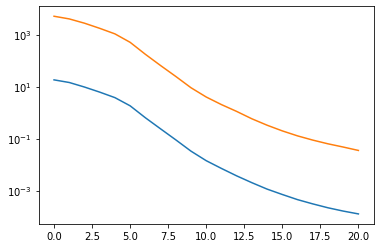

CPU times: user 1min 19s, sys: 5.15 s, total: 1min 25s
Wall time: 1min 12s


In [25]:
%%time
l_train = 10 ** 9
l_test = 10 ** 9

while l_train > 10 ** -4:
    # train
    l_train = 0
    
    for train_s, train_E in train_dataset:
        l_train += crbm.train(train_s, train_E / temp)
    
    
    l_train = l_train / N_TRAIN_BATCHES
    #for test_x, test_y in tqdm(test_ds, total=N_TEST_BATCHES):
    #l_test, acc_test = mps.compute_loss_accuracy(x_test, y_test)
        
    # plot results
    
    if epoch % 100 == 0:
        l_test = crbm.compute_loss(states_test, E_phys_test / temp)
        
        loss_train.append(l_train) 
        loss_test.append(l_test)
        
        display.clear_output()

        print(
            f"Epoch: {epoch} | loss test: {loss_test[-1]}| loss train: {loss_train[-1]}| ltest/ltrain: {loss_test[-1]/loss_train[-1]}"
        )
        plt.plot(loss_train)
        plt.plot(loss_test)
        plt.yscale("log")
        plt.show()
    epoch += 1

The learned convolutional filters show the effective interaction between nearest neighbours.

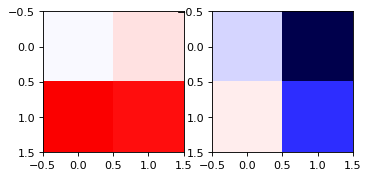

In [26]:
W = crbm.W.numpy()
vmax = np.max(abs(W))

f = plt.figure(figsize=(5, 10), dpi=80, facecolor='w', edgecolor='k')

f.add_subplot(1, 2, 1)
plt.imshow(W[:, :,0, 0], vmin =-vmax, vmax=vmax, cmap="seismic")

f.add_subplot(1, 2, 2)
plt.imshow(W[:,: ,0, 1], vmin =-vmax, vmax=vmax, cmap="seismic")

plt.show()

# Sampling

A state with $N=40$ is updated $5*10 ^4$ times using gibbs sampling.  Because the temperature T=1, is well bellow the critical temperature TC=2.269 it converges to the ground state.

In [0]:
N = 40
states = tf.random.uniform((1, N, N, 1))

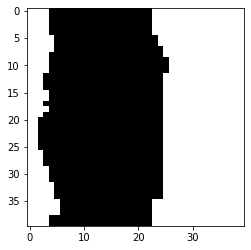

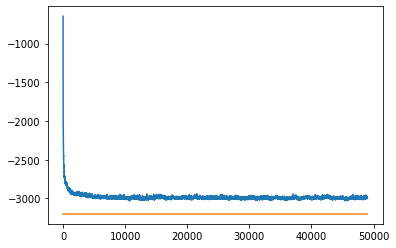

In [28]:
epochs = 5 * 10 ** 4
Es = []
for i in range(epochs):
    states = crbm.gibbs(states)
    Es.append(ising_energy(states)[0])
    
    if i % 1000 == 0:
        display.clear_output()
        plt.imshow(states.numpy()[0, :,:, 0], vmin=0, vmax=1, cmap="gray")
        plt.show()
        plt.plot(Es)
        plt.plot([0, len(Es)], [-2 * N**2, -2 * N**2])
        plt.show()

The minimal energy is $2N^2$

# Thermodynamic constants at different temperatures

Until now we only trained as CRBM at a $T=1$. Train differnt CRBM at different $T$s.




In [0]:
def train(T, crbm=None):
    if crbm is None:
        crbm = CRBM(filter_dims=(2, 2))
    
    l_train = 10 ** 9
    l_test = 10 ** 9
    epoch = 0
    while l_train > 10 ** -4:
        # train
        l_train = 0

        for train_s, train_E in train_dataset:
            l_train += crbm.train(train_s, train_E / T)
        
        l_train = l_train / N_TRAIN_BATCHES

        # plot results

        if epoch % 100 == 0:
            l_test = crbm.compute_loss(states_test, E_phys_test / T)

            display.clear_output()

            print(
                f"Temp: {T} | Epoch: {epoch} | loss test: {l_test}| loss train: {l_train}"
            )
        epoch += 1
   
    return crbm   

In [0]:
Ts = np.linspace(1.5, 3.5, 25)

Train different CRBM's at different temperatures.

In [0]:
#%%time
#crbms = [train(T) for T in Ts]

Faster. Train a CRBM at a temperature, save it, and then modify it's temperature and retrain it at the new temperature.

In [32]:
%%time
crbm = CRBM(filter_dims=(2, 2))
crbms = []
T_old = Ts[0]
for T in Ts:
    crbm_new = CRBM(filter_dims=(2, 2))
    
    crbm_new.W.assign(crbm.W / T * T_old )
    crbm_new.vbias.assign(crbm.vbias / T * T_old)
    crbm_new.hbias.assign(crbm.hbias / T * T_old)
    
    W_old = crbm_new.W.numpy()
    crbm = train(T, crbm_new)
    W_new = crbm.W.numpy()
    
    crbms.append(crbm)

Temp: 3.5 | Epoch: 800 | loss test: 0.034368474036455154| loss train: 0.00011765692033804953
CPU times: user 11min 52s, sys: 44.2 s, total: 12min 36s
Wall time: 9min 49s


# Montecarlo Simulations

The functions performs gibbs steps with a CRBM and saves the energy and magnetization in arrays.

In [0]:
def MC(crbm, states, steps, hidden_steps=10):
    Es = np.empty(steps)
    Ms = np.empty(steps)
    
    for i in range(steps):
        states = crbm.gibbs_k(states, k=hidden_steps)
        
        # Get the state out of the gpu
        state_np = states.numpy()
        Es[i] = ising_energy(state_np)[0]
        Ms[i] = (2 * state_np - 1).sum()
              
    return Es, Ms, states

This function will plot the thermodynamic constants

In [0]:
def plot_thermodynamics(Temp, Es, Cvs, mag, susceptibility):
    # ----------------------------------------------------------------------
    # Plot the Energy, Magnetization, Specific Heat and Susceptibility
    # ----------------------------------------------------------------------

    f = plt.figure(figsize=(18, 10), dpi=80, facecolor='w', edgecolor='k')
    xlabel = "T"
    
    sp = f.add_subplot(2, 2, 1)
    plt.xlabel(xlabel, fontsize=20)
    plt.ylabel("Energy ", fontsize=20)
    plt.scatter(Temp, Es)

    sp = f.add_subplot(2, 2, 2)
    plt.xlabel(xlabel, fontsize=20)
    plt.ylabel("Magnetization ", fontsize=20)
    plt.scatter(Temp, mag)

    sp = f.add_subplot(2, 2, 3)
    plt.xlabel(xlabel, fontsize=20)
    plt.ylabel("Specific Heat ", fontsize=20)

    plt.scatter(Temp, Cvs)
    plt.axvline(x=2.269)

    sp = f.add_subplot(2, 2, 4);
    plt.xlabel(xlabel, fontsize=20);
    plt.ylabel("Susceptibility", fontsize=20);
    
    plt.scatter(Temp, susceptibility)
    
    plt.show()

Initialize the step that will be used during the MC. There is an oportunity for parallelization in the Gpu if severall states are updated in the simulation. For simplicity only one states is used.



In [0]:
N = 25
states = tf.random.uniform((1, N, N, 1))

We start with the highest temperature and slowly lower it. First there is a warmup phase and then thermodynamic constants are recorded.

Temp:  1.5


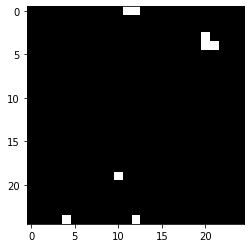

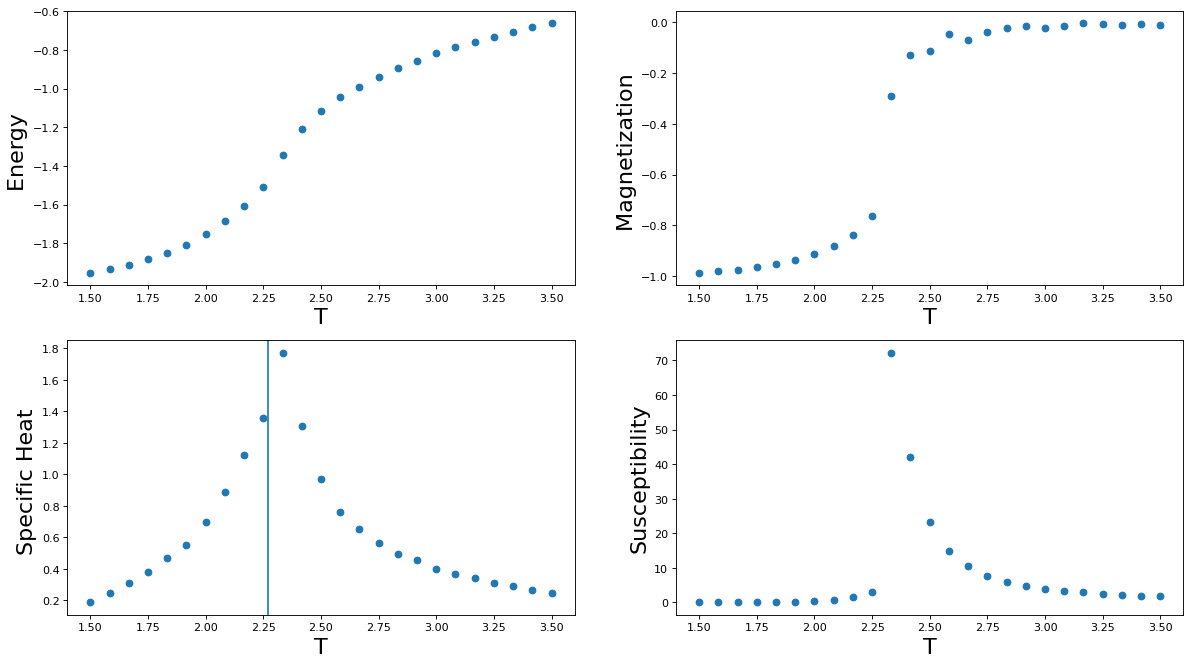

CPU times: user 35min 37s, sys: 47.3 s, total: 36min 24s
Wall time: 35min 11s


In [36]:
%%time

energy = []
magnetization = []
CV = []
susceptibility = []

e, m, states = MC(crbms[-1], states, 2 * 10 ** 4)
for i, crbm in enumerate(crbms[::-1]):
    # Warmup
    e, m, states = MC(crbm, states, 10 ** 3)
    
    # Mc Simulation
    e, m, states = MC(crbm, states,  2 * 10 ** 4)
    
    # Computing expectaion values
    e1 = e.mean()
    e2 = (e ** 2).mean()
    
    m1 = m.mean()
    m2 = (m ** 2).mean()
    
    
    energy.append(e1 / N ** 2)
    magnetization.append(m1 / N ** 2)
    CV.append( (e2 - e1 ** 2) / Ts[-i - 1] ** 2 / N ** 2 )
    susceptibility.append( (m2 - m1 ** 2) / Ts[-i - 1] / N ** 2 )
    
    
    display.clear_output()
    print("Temp: ", Ts[-i -1])
    plt.imshow(states.numpy()[0, :, :, 0], vmin=0, vmax=1, cmap="gray")
    plt.show()
    
    # Plot thermodynamics
    plot_thermodynamics(Ts[-i - 1:], energy[::-1], CV[::-1], magnetization[::-1], susceptibility[::-1])

Above you can see that the Magnetization colapses to 0 after the critical temperature $T_c=2.269$ and that the specific heat is maximal around $T_c$ as expected.

In [0]:
t1 = time.time()

In [38]:
(t1 - t0) / 60

48.01056731939316